## Data Challenge 1: Employee churn

**This notebook is intended to explore employee churn for 12 companies.**<br>
```It first loads the data from a csv, then creates a table of per-day employees for each company over the whole period in quesiton.``` <br><br>
```It explores the data graphically and then implements survival analysis using a Cox Proportional Hazards model.```
<br><br>
```Finally, I make suggestions for decreasing employee turnover and more data collection that may help inform this problem in the future.```
<br><br>


In [1]:
# it's not a huge amount of data; I can simply import it all as a dataframe
import pandas as pd

employee_data = pd.DataFrame.from_csv('/Users/z_home/zLearnPy/LeetCode_forGithub/Data_Challenge1/employee_retention_data.csv')

In [2]:
# It will be useful to have a binary column that tells whether an employee left or not
import numpy as np

employee_data['left'] = employee_data['quit_date'].notnull()


# Also, we should turn the current "string" dates into datetime fields
from datetime import datetime

employee_data['join'] = pd.to_datetime(employee_data['join_date'], format="%Y-%m-%d")
employee_data['quit'] = pd.to_datetime(employee_data['quit_date'], format="%Y-%m-%d")

# This allows us to have a "duration of employement" column as well
employee_data['emp_duration'] = employee_data['quit'] - employee_data['join']
employee_data['emp_duration'] = employee_data['emp_duration'].dt.days # convert TimeDelta to number


## Create a table of number of people employed

**From the data challenge text:**<br>
```Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. ```**You should create a table with 3 columns: day, employee_headcount, company_id.** <br><br>


In [3]:
# Create the requested table
from datetime import timedelta

# we were told how long they were monitored; therefore, we have a max duration
starting_date = datetime.strptime('2011/01/23', "%Y/%m/%d")
max_duration = datetime.strptime('2015/12/13', "%Y/%m/%d") - starting_date

init_date = [starting_date]*12
#per_day_table = pd.DataFrame([init_date, list(range(12)), [0]*12], columns=['Date', 'Company', 'Employees'])
per_day_table = pd.DataFrame({'Date': init_date, 'Company':list(range(1,13)), 'Employees':[0]*12})
#print(per_day_table)

for day_number in range(max_duration.days + 1): # doesn't cover the final date
    cur_date = starting_date + timedelta(days=day_number)
    add_to_table = pd.DataFrame({'Date': cur_date, 'Company':list(range(1,13)), 'Employees':[0]*12})
#    print(starting_date + timedelta(days=day_number))
    join_on_this_day = employee_data[employee_data['join'] == cur_date]
    if (not join_on_this_day.empty):
        for row in join_on_this_day.itertuples():
            add_to_table.loc[add_to_table.Company == row.company_id, 'Employees'] += 1
    quit_on_this_day = employee_data[employee_data['quit'] == cur_date]
    if (not quit_on_this_day.empty):
        for row in quit_on_this_day.itertuples():
            add_to_table.loc[add_to_table.Company == row.company_id, 'Employees'] -= 1
    per_day_table = pd.concat([per_day_table, add_to_table], axis=0)

print(per_day_table.iloc[100:115,:]) # just to confirm that it looks as expected

# Store the requested table in case we need it later
per_day_table.to_csv('/Users/z_home/zLearnPy/LeetCode_forGithub/Data_Challenge1/employees_per_day.csv')

    Company       Date  Employees
4         5 2011-01-30          0
5         6 2011-01-30          0
6         7 2011-01-30          0
7         8 2011-01-30          0
8         9 2011-01-30          0
9        10 2011-01-30          0
10       11 2011-01-30          0
11       12 2011-01-30          0
0         1 2011-01-31         30
1         2 2011-01-31         12
2         3 2011-01-31          7
3         4 2011-01-31          5
4         5 2011-01-31          7
5         6 2011-01-31          7
6         7 2011-01-31          6


## Explore the data

**It may be useful to understand characteristics of the data visually.**<br>
```When trying to figure out why people left a company (if they did) (with the data we have), it's important to understand the relationships between the data. Graphs can help.```<br><br>

1224 0.565359477124 0.495709732354
2062 0.55916585839 0.496487060457
4222 0.522501184273 0.499493440103
961 0.550468262227 0.497446433808
8486 0.544543954749 0.498011883488
1291 0.55151045701 0.497339595064
865 0.554913294798 0.496975381739
1755 0.560113960114 0.496373157815
2749 0.556929792652 0.496748425975
1047 0.553008595989 0.497182148464
16 0.75 0.433012701892
24 0.5 0.5


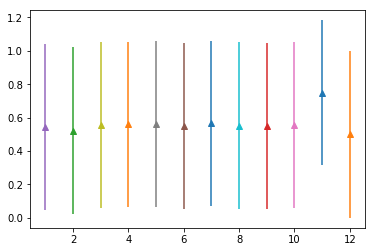

In [4]:
import matplotlib.pyplot as plt

# Let's see what the variation in retention rate looks like, per company
plt.clf()
for company in employee_data.company_id.unique():
    comp_rows = employee_data.loc[employee_data['company_id']==company]
    plt.errorbar(company, np.mean(comp_rows['left']), 
                 np.std(comp_rows['left']), linestyle='None', marker='^')
    print(len(comp_rows), np.mean(comp_rows['left']), 
          np.std(comp_rows['left']))

plt.show()


customer_service 9180 0.554901960784 0.49697663396
marketing 3167 0.562993369119 0.496015962895
data_science 3190 0.527272727273 0.499255644282
engineer 4613 0.512031216128 0.49985522888
sales 3172 0.570933165195 0.494942911936
design 1380 0.563768115942 0.495916956142


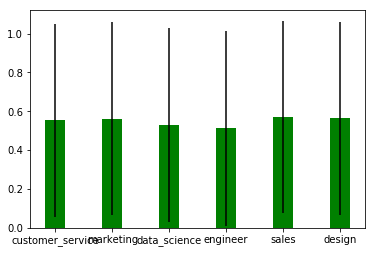

In [5]:
# Let's see what the variation in retention rate looks like, per department
plt.clf()
depts = [''] # first tick is at zero, so make that one blank
means = []
stdevs = []
for department in employee_data.dept.unique():
    depts.append(department)
    dept_rows = employee_data.loc[employee_data['dept']==department]
    means.append(np.mean(dept_rows['left']))
    stdevs.append(np.std(dept_rows['left']))
    print(department, len(dept_rows), np.mean(dept_rows['left']), 
          np.std(dept_rows['left']))

fig, ax = plt.subplots()
bar_width = 0.35
rects1 = ax.bar(np.arange(len(means)), means, bar_width, color='green', yerr=stdevs)
ax.set_xticklabels(depts)
                  
plt.show()

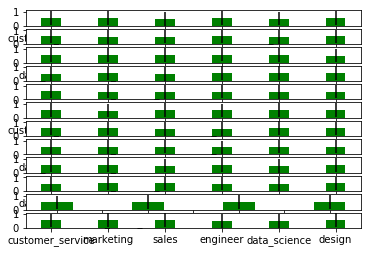

In [6]:
# Let's see what the variation in retention rate looks like, per company+department
plt.clf()
fig, ax = plt.subplots(12,1)
for idx, company in enumerate(employee_data.company_id.unique()):
    depts = [''] # first tick is at zero, so make that one blank
    means = []
    stdevs = []

    comp_rows = employee_data.loc[employee_data['company_id']==company]
    for department in comp_rows.dept.unique():
        depts.append(department)
        dept_rows = employee_data.loc[employee_data['dept']==department]
        means.append(np.mean(dept_rows['left']))
        stdevs.append(np.std(dept_rows['left']))

    bar_width = 0.35
    rects1 = ax[idx].bar(np.arange(len(means)), means, bar_width, color='green', yerr=stdevs)
    ax[idx].set_xticklabels(depts)
                  
plt.show()

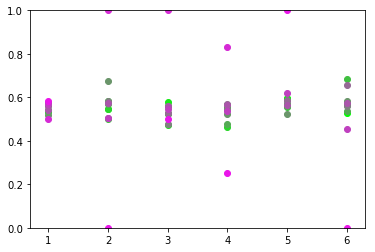

In [7]:
# Let's try company+department in a more informative way
import pylab

dept_dict = {'customer_service': 1, 'marketing': 2, 'data_science': 3, 
             'engineer': 4, 'sales': 5, 'design': 6}

plt.clf()

fig = plt.figure()
ax = fig.add_subplot(111)

for idx, company in enumerate(employee_data.company_id.unique()):
    xVals = []
    yVals = []
    comp_rows = employee_data.loc[employee_data['company_id']==company]
    for department in comp_rows.dept.unique():
        dept_rows = comp_rows.loc[comp_rows['dept']==department]
        xVals.append(dept_dict[department])
        yVals.append(np.mean(dept_rows['left']))
    ax.scatter(xVals, yVals, color=(idx/12, 1-(idx/12), idx/12))

pylab.ylim([0,1])
plt.show()

customer_service 9180 82245.4248366013 31578.115022099213
marketing 3167 135598.04231133565 52370.45094873777
data_science 3190 206885.8934169279 78649.47525409248
engineer 4613 205544.54801647516 78044.05490380139
sales 3172 135912.35813366962 52328.063605671094
design 1380 137460.86956521738 52368.17048936571


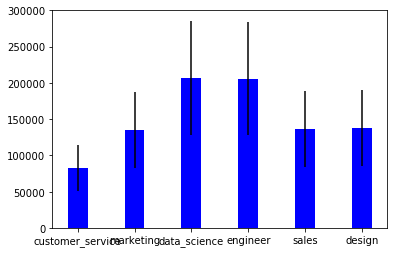

In [20]:
# I wonder what the average salary is per department
plt.clf()
depts = [''] # first tick is at zero, so make that one blank
means = []
stdevs = []
for department in employee_data.dept.unique():
    depts.append(department)
    dept_rows = employee_data.loc[employee_data['dept']==department]
    means.append(np.mean(dept_rows['salary']))
    stdevs.append(np.std(dept_rows['salary']))
    print(department, len(dept_rows), np.mean(dept_rows['salary']), 
          np.std(dept_rows['salary']))

fig, ax = plt.subplots()
bar_width = 0.35
rects1 = ax.bar(np.arange(len(means)), means, bar_width, color='blue', yerr=stdevs)
ax.set_xticklabels(depts)
                  
plt.show()

customer_service 9180 14.171132897603487 8.04475600327776
marketing 3167 13.993684875276287 8.240578122059244
data_science 3190 14.189028213166145 8.007304971801013
engineer 4613 14.172122263169305 8.133310136660963
sales 3172 13.97982345523329 8.084334576364496
design 1380 14.197826086956521 8.080168668343795


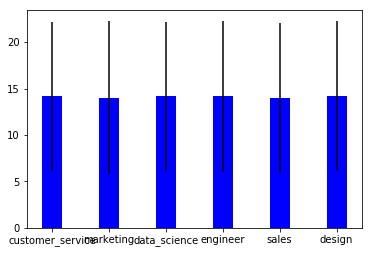

In [21]:
# Is there a significant difference in seniority per department?
plt.clf()
depts = [''] # first tick is at zero, so make that one blank
means = []
stdevs = []
for department in employee_data.dept.unique():
    depts.append(department)
    dept_rows = employee_data.loc[employee_data['dept']==department]
    means.append(np.mean(dept_rows['seniority']))
    stdevs.append(np.std(dept_rows['seniority']))
    print(department, len(dept_rows), np.mean(dept_rows['seniority']), 
          np.std(dept_rows['seniority']))

fig, ax = plt.subplots()
bar_width = 0.35
rects1 = ax.bar(np.arange(len(means)), means, bar_width, color='blue', yerr=stdevs)
ax.set_xticklabels(depts)
                  
plt.show()

## There are clearly differences in retention rate considering company and department

**Given that, a model should be able to predict these differences.**<br>
Since the goal is to determine the time until an event, a survival analysis seems like the appropriate model. In particular, a Cox Proportional Hazards model will attempt to identify the contributions of particular variables (in our case, company, department, salary, and seniority) to the "hazard" of leaving a company. <br><br>

In [10]:
# The "lifelines" toolbox needs the data in a single dataframe

employ_cox_input = employee_data.drop(['join_date', 'quit_date', 'quit', 'join'], axis=1)

# Normally I would 'one hot encode' the department; however, Cox PH doesn't deal well with this
#employ_cox_input = pd.concat([employ_cox_input, # one hot encode this
#                              pd.get_dummies(employ_cox_input.dept)], axis=1)
#employ_cox_input = employ_cox_input.drop(['dept'], axis=1) # no need for this column now

# Cox doesn't seem to like One Hot Encoding... try just an int encoding
employ_cox_input = employ_cox_input.replace({'dept': dept_dict})

# Cox expects a duration even for the people who didn't leave; use max + 1
employ_cox_input['emp_duration'].fillna(max_duration.days + 1, inplace=True)

# We should normalize the variables, since (e.g.) salary is in a much higher range than others
employ_cox_input['salary_norm'] = (employ_cox_input['salary'] - np.mean(employ_cox_input['salary'])) / np.std(employ_cox_input['salary'])
employ_cox_input['seniority_norm'] = (employ_cox_input['seniority'] - np.mean(employ_cox_input['seniority'])) / np.std(employ_cox_input['seniority'])
employ_cox_input = employ_cox_input.drop(['salary'], axis=1) # no need for this column now
employ_cox_input = employ_cox_input.drop(['seniority'], axis=1) # no need for this column now

print(employ_cox_input.iloc[0:5,:]) # just to prove that the table looks right

             company_id  dept   left  emp_duration  salary_norm  \
employee_id                                                       
13021.0               7     1   True         585.0    -0.646667   
825355.0              7     2   True         340.0     0.589254   
927315.0              4     2  False        1786.0    -0.488890   
662910.0              7     1   True         389.0    -0.304817   
256971.0              2     3   True        1040.0     1.812026   

             seniority_norm  
employee_id                  
13021.0            1.714870  
825355.0           0.725916  
927315.0          -0.015799  
662910.0           0.725916  
256971.0           1.096774  


In [9]:
# Now, use the Cox Proportional Hazards model to fit a survival curve

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(employ_cox_input, 'emp_duration', event_col='left')
cph.print_summary()

n=24702, number of events=13510

                  coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
company_id      0.0011     1.0011    0.0033  0.3354 0.7373     -0.0053      0.0075     
dept            0.0222     1.0224    0.0060  3.6922 0.0002      0.0104      0.0340  ***
salary_norm    -0.1121     0.8939    0.0124 -9.0197 0.0000     -0.1365     -0.0877  ***
seniority_norm  0.0654     1.0676    0.0110  5.9663 0.0000      0.0439      0.0869  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.522


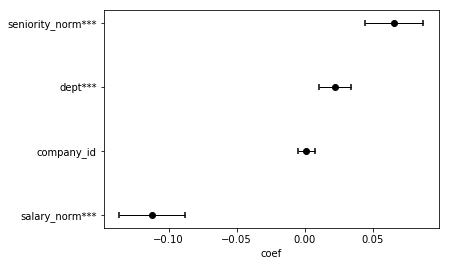

In [12]:
# apparently Lifelines requires matplotlib to be "inline"
%matplotlib inline

cph.plot()

In [19]:
# 0.522 is not high concordance, but we should still cross-validate

from lifelines.utils import k_fold_cross_validation

scores = k_fold_cross_validation(cph, employ_cox_input, 'emp_duration', event_col='left', k=5)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.52037980949011686, 0.5144078662558581, 0.51732785500730216, 0.53101129892292076, 0.52002510599187024]
0.520630387134
0.0056181664004


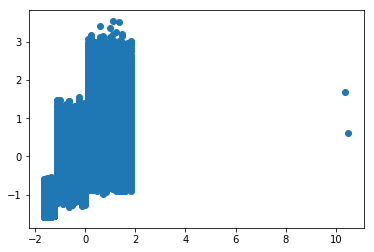

In [13]:
# Let's see if salary and seniority are correlated (I assume they should be?)

plt.clf()
plt.scatter(employ_cox_input['seniority_norm'], employ_cox_input['salary_norm'])
plt.show()

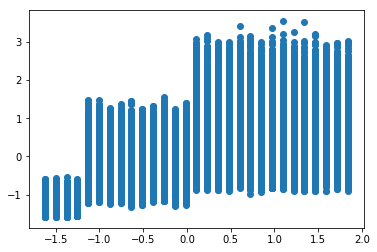

(0.56101091342583398, 0.0)
R-squared = 0.314733244983


In [17]:
# Interesting... a couple of people are large outliers in terms of seniority; remove them
cox_input_noOutliers = employ_cox_input[employ_cox_input.seniority_norm < 5]

plt.clf()
plt.scatter(cox_input_noOutliers['seniority_norm'], cox_input_noOutliers['salary_norm'])
plt.show()

from scipy.stats.stats import pearsonr
corr_coeff = pearsonr(cox_input_noOutliers['seniority_norm'], cox_input_noOutliers['salary_norm'])
print(corr_coeff)
print('R-squared = %s' % corr_coeff[0]**2)


In [18]:
# Let's try removing one of these correlated variables and see how much predictive power we lose
cox_input_noOutliers = cox_input_noOutliers.drop(['seniority_norm'], axis=1)

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(cox_input_noOutliers, 'emp_duration', event_col='left')
cph.print_summary()

n=24700, number of events=13508

               coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
company_id   0.0036     1.0036    0.0032  1.1171 0.2640     -0.0027      0.0099     
dept         0.0103     1.0104    0.0057  1.8087 0.0705     -0.0009      0.0216    .
salary_norm -0.0649     0.9371    0.0095 -6.8686 0.0000     -0.0835     -0.0464  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.512


## Conclusions

**The Cox PH model is not very predictive.**<br>
```The concordance of the model is 0.52 (with all variables). This means that there is a 52% chance that, for a pair of randomly chosen comparable samples, the sample with the higher risk prediction will experience an event before the other sample. Since random chance would be 50%, our model is only adding 2% to our ability to predict whether an employee will leave or not.``` <br><br>
**The department, salary, and seniority all have very low p values (p < .001).**<br> 
```This means that even though the model does not predict well, these variables each have a significant impact on the outcome.```
<br>```Specifically, people with high salary are less likely to leave, but those with high seniority are more likely to leave. These make sense, since those with high seniority (without commensurate salary) are likely to either retire or find higher-salary positions elsewhere.```
<br>```Department also has a significant impact on employee turnover. Employees in sales, design, marketing, and cusomter service are significantly more likely to leave than employees in engineering or data science. This almost certainly due to the salary differences, as these two departments make significantly more than others.```
<br><br>
**Salary and seniority are correlated with one another (r^2 = .31).**<br> 
```This means that these two variables are likely explaining similar things within the model. Ideally we would either remove one or combine them in some way so as to have independent input variables.```<br><br>


## Collecting more data

**Given that this model is not very predictive, it would be good to collect more data that will help with this prediction.**<br>
```We can imagine several variables that might be more predictive of employee churn than (e.g.) seniority. Some of these variables may be very easy to obtain; for example, age may be quite predictive, at least in the higher ranges (around retirement).``` <br><br>
```However, if we could only obtain one more piece of data, I think the most valuable would be some sort of performance metric. This could be number of projects successfully completed, number of promotions, or something similar. Similar studies at other companies have shown that employees who perform very well or poorly tend to leave at much higher rates than those who perform merely adequately.```<br><br>